In [1]:
import sys
sys.path.append("../")

In [2]:
from pathlib import Path
from functools import partial

import joblib
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from fastai.text import LanguageModelLoader, LanguageModelData
from fastai.core import T
from fastai.rnn_reg import EmbeddingDropout
from torch.optim import Adam
import torch.nn as nn
import torch
import torch.nn.functional as F

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [3]:
tokens = joblib.load("../data/tokens_word.pkl")

In [4]:
# Filter out empty rows
print(len(tokens))
tokens = [x for x in tokens if x.shape[0] > 0]
print(len(tokens))

367208
367208


In [5]:
trn_tokens, val_tokens = train_test_split(tokens, test_size=0.2, random_state=9)
val_tokens, tst_tokens = train_test_split(val_tokens, test_size=0.5, random_state=9)

In [6]:
def get_voc_stats(tokens):
    total_tokens = np.sum([x.shape[0] for x in tokens])
    unks = np.sum([np.sum(x == 1) for x in tokens])
    print("Total tokens: %d\nUnknown Percentage: %.2f %%" % (total_tokens, unks * 100 / total_tokens))
get_voc_stats(tokens)

Total tokens: 97937703
Unknown Percentage: 14.89 %


In [7]:
bptt = 100
batch_size = 128
n_tok = int(np.max([np.max(x) for x in tokens]) + 1)
trn_loader = LanguageModelLoader(
    np.concatenate(trn_tokens), batch_size, bptt)
val_loader = LanguageModelLoader(
    np.concatenate(val_tokens), batch_size, bptt)
tst_loader = LanguageModelLoader(
    np.concatenate(tst_tokens), batch_size, bptt)

In [8]:
from collections import Counter
tmp = []
for i in range(10000):
    for j in range(1, trn_tokens[i].shape[0]):
        if trn_tokens[i][j] == 1:
            tmp.append(trn_tokens[i][j-1])
Counter(tmp).most_common(10)

[(1, 56521),
 (2, 29966),
 (3, 26778),
 (5, 19607),
 (4, 16459),
 (19, 8330),
 (6, 8020),
 (8, 6348),
 (10, 5468),
 (32, 4885)]

In [9]:
from collections import Counter
tmp = []
for i in range(10000):
    for j in range(1, trn_tokens[i].shape[0]-1):
        if trn_tokens[i][j] == 4:
            tmp.append(trn_tokens[i][j+1])
Counter(tmp).most_common(10)

[(1, 16458),
 (20, 9225),
 (6, 4395),
 (16, 1642),
 (23, 1119),
 (45, 1033),
 (109, 993),
 (36, 927),
 (29, 876),
 (95, 846)]

In [10]:
mapping = joblib.load("../data/mapping_word.pkl")

In [11]:
itos = ['<pad>'] + ['<unk>'] *  n_tok
for k, v in mapping.items():
    itos[v] = k

In [12]:
itos[4]

'。'

In [13]:
path = Path("../data/cache/lm_word/")
path.mkdir(parents=True, exist_ok=True)
model_data = LanguageModelData(
    path, pad_idx=0, n_tok=n_tok, trn_dl=trn_loader, val_dl=val_loader, test_dl=tst_loader
)

### QRNN Model

In [ ]:
drops = np.array([0.05, 0.1, 0.05, 0, 0.1])
learner = model_data.get_model(
    partial(Adam, betas=(0.8, 0.999)),
    emb_sz=300, n_hid=500, n_layers=4,
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2],
    dropoute=drops[3], dropouth=drops[4], qrnn=True
)

In [ ]:
learner.clip = 25.
learner.lr_find(start_lr=1e-5, end_lr=1, linear=False)
learner.sched.plot()

In [ ]:
lrs = 2e-3
learner.fit(lrs, 1, wds=1e-7, use_clr=(50, 3), cycle_len=10, use_wd_sched=True)

In [ ]:
learner.sched.plot_lr()

In [ ]:
lrs = 5e-4
learner.fit(lrs, 1, wds=1e-7, use_clr=(50, 3), cycle_len=10, use_wd_sched=True)

In [ ]:
learner.sched.plot_loss()

In [ ]:
learner.save("lm_qrnn")
learner.save_encoder("lm_qrnn_enc")

In [ ]:
learner.load("lm_qrnn")

### LSTM

In [14]:
drops = np.array([0.1, 0.1, 0.05, 0, 0.1])
learner = model_data.get_model(
    partial(Adam, betas=(0.7, 0.99)),
    emb_sz=300, n_hid=500, n_layers=3,
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2],
    dropoute=drops[3], dropouth=drops[4], qrnn=False
)

 88%|████████▊ | 5362/6120 [18:27<02:36,  4.84it/s, loss=18.9]

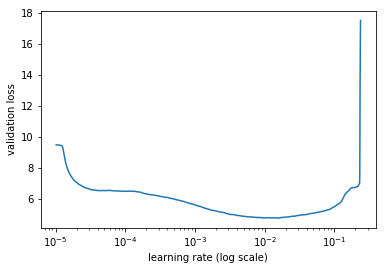

In [15]:
learner.clip = 10.
learner.lr_find(start_lr=1e-5, end_lr=1, linear=False)
learner.sched.plot()

In [16]:
lrs = 3e-3
learner.fit(lrs, 1, wds=1e-7, use_clr=(50, 3), cycle_len=10, use_wd_sched=True)

epoch      trn_loss   val_loss                                
    0      4.599382   4.512122  
    1      4.300838   4.19133                                 
    2      4.229062   4.113047                                
    3      4.17813    4.055418                                
    4      4.14       4.010401                                
    5      4.110208   3.978438                                
    6      4.084675   3.953387                                
    7      4.058134   3.931805                                
    8      4.045278   3.91166                                 
    9      4.017105   3.895606                                


[3.895605748477801]

In [18]:
learner.save("lm_lstm")

In [19]:
lrs = 1e-3
learner.fit(lrs, 1, wds=1e-7, use_clr=(50, 3), cycle_len=10, use_wd_sched=True)

epoch      trn_loss   val_loss                                
    0      4.022002   3.899044  
    1      4.034041   3.905991                                
    2      4.043982   3.913612                                
    3      4.046286   3.913167                                
    4      4.044897   3.909215                                
 34%|███▍      | 2071/6120 [07:17<14:14,  4.74it/s, loss=4.03]

KeyboardInterrupt: 

In [ ]:
learner.sched.plot_lr()

In [ ]:
learner.save("lm_lstm")
learner.save_encoder("lm_lstm_enc")

In [ ]:
# Use tons of memory...
# pred, targ = learner.predict_with_targs(is_test=True)

In [ ]:
tmp_iter = iter(trn_loader)

In [ ]:
next(tmp_iter)[0].shape

In [20]:
learner.load("lm_lstm")

## Test the model

In [21]:
learner.model.eval()

SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(13003, 300, padding_idx=0)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(13003, 300, padding_idx=0)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(300, 500)
      )
      (1): WeightDrop(
        (module): LSTM(500, 500)
      )
      (2): WeightDrop(
        (module): LSTM(500, 300)
      )
    )
    (dropouti): LockedDropout()
    (dropouths): ModuleList(
      (0): LockedDropout()
      (1): LockedDropout()
      (2): LockedDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=300, out_features=13003, bias=False)
    (dropout): LockedDropout()
  )
)

### Next Character Inference

In [22]:
!pip install jieba
import jieba

    100% |################################| 7.3MB 204kB/s ta 0:00:01
  Running setup.py bdist_wheel for jieba ... done
  Stored in directory: /home/docker/.cache/pip/wheels/c9/c7/63/a9ec0322ccc7c365fd51e475942a82395807186e94f0522243
Successfully built jieba


In [31]:
texts = "德国 是 世界 大国 之一 ， 其 国内 生产 总 值 以 国际 汇率 计"
tokens = list(map(lambda x: mapping.get(x, 1), texts.split(" ")))
tokens

[298, 7, 148, 7074, 226, 2, 42, 870, 450, 427, 3231, 25, 154, 11036, 3299]

In [32]:
logits, _, _ = learner.model(T(tokens).unsqueeze(1))
logits.shape

torch.Size([15, 13003])

In [33]:
sorted_idx = np.argsort(logits.data.cpu().numpy(), 1)
preds = []
for i in range(1, 4):
      preds.append(list(map(lambda x: itos[x], sorted_idx[:, -i])))
# preds = list(map(lambda x: itos[x], np.argmax(logits.data.cpu().numpy(), 1)))
pd.DataFrame({"orig": list(texts.split(" ")) + [" "], 
              "pred_1": [""] + preds[0], "pred_2": [""] + preds[1], "pred_3": [""] + preds[2]})

,orig,pred_1,pred_2,pred_3
0,德国,,,
1,是,<unk>,的,、
2,世界,<unk>,最,世界
3,大国,上,最,第二
4,之一,。,，,之一
5,，,。,，,；
6,其,<unk>,而,仅次于
7,国内,<unk>,经济,主要
8,生产,生产总值,经济,<unk>
9,总,的,<unk>,总量


In [38]:
def eval(texts):
    learner.model[0].reset()
    tokens = list(map(lambda x: mapping.get(x, 1), texts))
    logits, _, _ = learner.model(T(tokens).unsqueeze(1))
    sorted_idx = np.argsort(logits.data.cpu().numpy(), 1)
    preds = []
    for i in range(1, 4):
          preds.append(list(map(lambda x: itos[x], sorted_idx[:, -i])))
    # preds = list(map(lambda x: itos[x], np.argmax(logits.data.cpu().numpy(), 1)))
    return pd.DataFrame({"orig": [x for x in texts] + [" "], 
                  "pred_1": [""] + preds[0], "pred_2": [""] + preds[1], "pred_3": [""] + preds[2]})

In [40]:
eval(list(jieba.cut("在现代印刷媒体，卡通是一种通常有幽默色")))

,orig,pred_1,pred_2,pred_3
0,在,,,
1,现代,<unk>,中国,美国
2,印刷,<unk>,的,社会
3,媒体,中,的,<unk>
4,，,中,上,的
5,卡通,<unk>,并,在
6,是,频道,<unk>,杂志
7,一种,<unk>,一,由
8,通常,的,<unk>,，
9,有,的,<unk>,在


In [42]:
eval(list(jieba.cut("对中国与南洋发动全面的战争。1990年代，中")))

,orig,pred_1,pred_2,pred_3
0,对,,,
1,中国,<unk>,此,其
2,与,大陆,的,人
3,南洋,中国,<unk>,日本
4,发动,的,地区,<unk>
5,全面,的,战争,<unk>
6,的,战争,的,<unk>
7,战争,<unk>,战争,侵略
8,。,，,。,的
9,1990,<unk>,,在


### Generate Sentence

In [89]:
import random

def get_tokens(texts, seg=True):
    if seg:
        texts = list(jieba.cut(texts))
    return list(map(lambda x: mapping.get(x, 1), texts))

def generate_text(tokens,N=25):    
    preds = []          
    for i in range(N):   
        learner.model[0].reset()          
        logits, _, _ = learner.model(T(tokens).unsqueeze(1))
        probs = F.softmax(logits).data.cpu().numpy()[-1, :]
        candidates = np.argsort(probs)[::-1]
        while True:
            candidate = np.random.choice(candidates, p=probs[candidates])
            if candidate > 1:
                print(probs[candidates][:3], probs[candidate])
                preds.append(candidate)
                break
        # for candidate in candidates:
        #     if candidate > 1 and ord(itos[candidate]) > 255 and (random.random() < probs[candidate] or probs[candidate] < 0.2):
        #         print(probs[candidate])
        #         preds.append(candidate)
        #         break
        # tokens  = [preds[-1]]# 
        tokens.append(preds[-1])
        # tokens = [:1]
        print("".join([itos[x] for x in tokens])) 
    
generate_text(get_tokens("德国是世界大国之一，其国内生产总值以国际汇率为主，"))

[0.0849  0.04522 0.04519] 0.0020851453
德国是<unk>之一，其国内生产总值以国际汇率为主，各国
[0.09918 0.08674 0.03713] 0.004072963
德国是<unk>之一，其国内生产总值以国际汇率为主，各国之
[0.12832 0.02331 0.01787] 0.00030839004
德国是<unk>之一，其国内生产总值以国际汇率为主，各国之武器
[0.06282 0.049   0.02834] 0.017302074
德国是<unk>之一，其国内生产总值以国际汇率为主，各国之武器也
[0.09091 0.04467 0.03473] 0.03472741
德国是<unk>之一，其国内生产总值以国际汇率为主，各国之武器也都
[0.11333 0.08056 0.03986] 0.003928228
德国是<unk>之一，其国内生产总值以国际汇率为主，各国之武器也都已
[0.11237 0.04534 0.04051] 0.04050917
德国是<unk>之一，其国内生产总值以国际汇率为主，各国之武器也都已有
[0.11852 0.0384  0.03166] 0.00021041263
德国是<unk>之一，其国内生产总值以国际汇率为主，各国之武器也都已有取代
[0.31203 0.19704 0.09372] 0.3120301
德国是<unk>之一，其国内生产总值以国际汇率为主，各国之武器也都已有取代。
[0.21283 0.11078 0.04112] 0.21283479
德国是<unk>之一，其国内生产总值以国际汇率为主，各国之武器也都已有取代。
[0.3737  0.03779 0.03099] 0.0029591594
德国是<unk>之一，其国内生产总值以国际汇率为主，各国之武器也都已有取代。2011年
[0.14677 0.06127 0.06048] 0.1467675
德国是<unk>之一，其国内生产总值以国际汇率为主，各国之武器也都已有取代。2011年，
[0.41788 0.02925 0.02721] 0.00022997423
德国是<unk>之一，其国内生产总值以国际汇率为主，各国之武器也都已有取代。2011年，依据
[0.26969 0.17865 0.03119

In [92]:
generate_text(get_tokens("德国 是 世界 大国 之一 ， 其 国内 生产 总 值 以 国际 汇率 为主 ，".split(" "), seg=False))

[0.07484 0.05312 0.04248] 0.00071701215
德国是世界大国之一，其国内生产总值以国际汇率为主，年
[0.29586 0.10333 0.10185] 0.015437807
德国是世界大国之一，其国内生产总值以国际汇率为主，年收入
[0.21442 0.1808  0.10822] 0.00040535812
德国是世界大国之一，其国内生产总值以国际汇率为主，年收入700
[0.36304 0.12111 0.10409] 0.072563
德国是世界大国之一，其国内生产总值以国际汇率为主，年收入700,
[0.65283 0.29717 0.01147] 0.65283036
德国是世界大国之一，其国内生产总值以国际汇率为主，年收入700,000
[0.58227 0.15969 0.08407] 0.58227104
德国是世界大国之一，其国内生产总值以国际汇率为主，年收入700,000美元
[0.59681 0.30766 0.031  ] 0.5968141
德国是世界大国之一，其国内生产总值以国际汇率为主，年收入700,000美元。
[0.24557 0.0916  0.04402] 0.0058658537
德国是世界大国之一，其国内生产总值以国际汇率为主，年收入700,000美元。根据
[0.14143 0.05549 0.05085] 0.016316457
德国是世界大国之一，其国内生产总值以国际汇率为主，年收入700,000美元。根据世界
[0.21682 0.13947 0.07855] 0.21682173
德国是世界大国之一，其国内生产总值以国际汇率为主，年收入700,000美元。根据世界银行
[0.22654 0.09074 0.04611] 0.006457782
德国是世界大国之一，其国内生产总值以国际汇率为主，年收入700,000美元。根据世界银行网站
[0.20531 0.11473 0.09224] 0.20530608
德国是世界大国之一，其国内生产总值以国际汇率为主，年收入700,000美元。根据世界银行网站的
[0.38944 0.09377 0.0578 ] 0.3894443
德国是世界大国之一，其国内生产总值以国际汇率为主，年收入700,000美元。根据世界银行网站的统计
[0.6

In [91]:
generate_text(get_tokens("在现代印刷媒体，卡通是一种通常有幽默色"))

[0.57148 0.10214 0.08893] 0.10213592
在现代印刷媒体，卡通是<unk>通常有幽默色，
[0.12241 0.04842 0.02696] 0.00512519
在现代印刷媒体，卡通是<unk>通常有幽默色，被
[0.16758 0.11191 0.06359] 0.02920835
在现代印刷媒体，卡通是<unk>通常有幽默色，被人
[0.27767 0.09662 0.06675] 0.0006173651
在现代印刷媒体，卡通是<unk>通常有幽默色，被人笑
[0.20633 0.08822 0.06203] 0.008166621
在现代印刷媒体，卡通是<unk>通常有幽默色，被人笑，
[0.14941 0.03693 0.03217] 0.002003036
在现代印刷媒体，卡通是<unk>通常有幽默色，被人笑，指
[0.24453 0.09932 0.02587] 0.005567843
在现代印刷媒体，卡通是<unk>通常有幽默色，被人笑，指为
[0.31994 0.05797 0.03811] 0.0013306263
在现代印刷媒体，卡通是<unk>通常有幽默色，被人笑，指为当时
[0.22526 0.11243 0.0357 ] 0.00038319558
在现代印刷媒体，卡通是<unk>通常有幽默色，被人笑，指为当时有的
[0.22117 0.07134 0.01125] 0.00091244903
在现代印刷媒体，卡通是<unk>通常有幽默色，被人笑，指为当时有的其他
[0.17724 0.03044 0.0282 ] 0.0008020848
在现代印刷媒体，卡通是<unk>通常有幽默色，被人笑，指为当时有的其他「
[0.38756 0.00886 0.00842] 0.000650396
在现代印刷媒体，卡通是<unk>通常有幽默色，被人笑，指为当时有的其他「他们
[0.32084 0.17149 0.1125 ] 0.17148939
在现代印刷媒体，卡通是<unk>通常有幽默色，被人笑，指为当时有的其他「他们的
[0.36169 0.01851 0.01332] 0.00017412976
在现代印刷媒体，卡通是<unk>通常有幽默色，被人笑，指为当时有的其他「他们的图像
[0.38612 0.111

In [52]:
generate_text(get_tokens("在现代印刷媒体，第"))

[0.11664 0.0809  0.063  ] 0.013735259
在现代印刷媒体，第21
[0.1503  0.12699 0.06979] 0.15030143
在现代印刷媒体，第21届
[0.29316 0.04064 0.02644] 0.0003290113
在现代印刷媒体，第21届蒙特利尔
[0.27749 0.25952 0.04082] 0.00036318615
在现代印刷媒体，第21届蒙特利尔传媒
[0.15316 0.14406 0.12543] 0.004984978
在现代印刷媒体，第21届蒙特利尔传媒世界
[0.58364 0.06818 0.0337 ] 0.58364475
在现代印刷媒体，第21届蒙特利尔传媒世界博览会
[0.1648  0.09174 0.06011] 0.005921887
在现代印刷媒体，第21届蒙特利尔传媒世界博览会正式
[0.09121 0.06231 0.05032] 0.00029816577
在现代印刷媒体，第21届蒙特利尔传媒世界博览会正式提供
[0.24674 0.11326 0.05285] 0.0031860475
在现代印刷媒体，第21届蒙特利尔传媒世界博览会正式提供使用
[0.3879  0.13697 0.09953] 0.38790128
在现代印刷媒体，第21届蒙特利尔传媒世界博览会正式提供使用。
[0.37138 0.09383 0.04414] 0.01921569
在现代印刷媒体，第21届蒙特利尔传媒世界博览会正式提供使用。《
[0.8653  0.03373 0.00391] 0.00019770922
在现代印刷媒体，第21届蒙特利尔传媒世界博览会正式提供使用。《世纪
[0.71019 0.09051 0.01247] 0.00024495873
在现代印刷媒体，第21届蒙特利尔传媒世界博览会正式提供使用。《世纪十八
[0.17896 0.13515 0.074  ] 0.04536766
在现代印刷媒体，第21届蒙特利尔传媒世界博览会正式提供使用。《世纪十八年
[0.51304 0.11689 0.02403] 4.435249e-06
在现代印刷媒体，第21届蒙特利尔传媒世界博览会正式提供使用。《世纪十八年客
[0.4205  0.04554 0.02305] 

In [53]:
generate_text(get_tokens("日本后来成为第二次世界大战的轴心国之一，对中国与南洋发动全面的战争。"))           

[0.21993 0.11504 0.06094] 0.0031887044
日本后来成为<unk>的<unk>之一，对中国与南洋发动全面的战争。此后
[0.43218 0.07533 0.03038] 0.030377774
日本后来成为<unk>的<unk>之一，对中国与南洋发动全面的战争。此后日本
[0.06742 0.0578  0.05238] 0.052381463
日本后来成为<unk>的<unk>之一，对中国与南洋发动全面的战争。此后日本政府
[0.06934 0.06929 0.06898] 0.009819492
日本后来成为<unk>的<unk>之一，对中国与南洋发动全面的战争。此后日本政府和
[0.15521 0.12348 0.07315] 0.0050978772
日本后来成为<unk>的<unk>之一，对中国与南洋发动全面的战争。此后日本政府和媒体
[0.07115 0.05296 0.05177] 0.0032551514
日本后来成为<unk>的<unk>之一，对中国与南洋发动全面的战争。此后日本政府和媒体有
[0.12189 0.11431 0.05374] 0.002374734
日本后来成为<unk>的<unk>之一，对中国与南洋发动全面的战争。此后日本政府和媒体有冲突
[0.58989 0.10965 0.07273] 0.1096453
日本后来成为<unk>的<unk>之一，对中国与南洋发动全面的战争。此后日本政府和媒体有冲突。
[0.1693  0.0792  0.05049] 0.00032899523
日本后来成为<unk>的<unk>之一，对中国与南洋发动全面的战争。此后日本政府和媒体有冲突。报导
[0.1343  0.103   0.07515] 0.13429593
日本后来成为<unk>的<unk>之一，对中国与南洋发动全面的战争。此后日本政府和媒体有冲突。报导称
[0.50977 0.07816 0.06281] 0.50976896
日本后来成为<unk>的<unk>之一，对中国与南洋发动全面的战争。此后日本政府和媒体有冲突。报导称，
[0.21276 0.09568 0.05249] 0.00014371001
日本后来成为<unk>的<unk>之一，对中国与南洋发动全面的战争。此后日本政府和媒体有冲

In [55]:
generate_text(get_tokens("传说日本于公元前660年2月11日建国，在公元4世纪出现首个统一政权，并于大化改新中确立了天皇的中央集权体制"
                         "。至平安时代结束前，日本透过文字、宗教、艺术、政治制度等从汉文化引进的事物，开始派生出今日为人所知的文化基"
                         "础。12世纪后的六百年间，日本由武家阶级创建的数个幕府及军事强人政权实际掌权，期间包括了政治纷乱的南北朝与"
                         "战国"))           

[0.39694 0.36526 0.02658] 0.36526316
传说日本于公元前<unk>年2月11日建国，在公元4世纪出现<unk>统一政权，并于<unk><unk>确立了天皇的<unk>体制。至平安时代结束前，日本透过文字、宗教、艺术、政治制度等<unk>文化引进的事物，开始派<unk>今日<unk>的文化基础。12世纪后的<unk>年间，日本由<unk>阶级创建的<unk>幕府及军事<unk>实际掌权，期间包括了政治<unk>的南北朝与战国时代
[0.41169 0.13265 0.10885] 0.41168737
传说日本于公元前<unk>年2月11日建国，在公元4世纪出现<unk>统一政权，并于<unk><unk>确立了天皇的<unk>体制。至平安时代结束前，日本透过文字、宗教、艺术、政治制度等<unk>文化引进的事物，开始派<unk>今日<unk>的文化基础。12世纪后的<unk>年间，日本由<unk>阶级创建的<unk>幕府及军事<unk>实际掌权，期间包括了政治<unk>的南北朝与战国时代的
[0.40085 0.02    0.01966] 0.0010712872
传说日本于公元前<unk>年2月11日建国，在公元4世纪出现<unk>统一政权，并于<unk><unk>确立了天皇的<unk>体制。至平安时代结束前，日本透过文字、宗教、艺术、政治制度等<unk>文化引进的事物，开始派<unk>今日<unk>的文化基础。12世纪后的<unk>年间，日本由<unk>阶级创建的<unk>幕府及军事<unk>实际掌权，期间包括了政治<unk>的南北朝与战国时代的古
[0.39935 0.11373 0.03979] 0.11373325
传说日本于公元前<unk>年2月11日建国，在公元4世纪出现<unk>统一政权，并于<unk><unk>确立了天皇的<unk>体制。至平安时代结束前，日本透过文字、宗教、艺术、政治制度等<unk>文化引进的事物，开始派<unk>今日<unk>的文化基础。12世纪后的<unk>年间，日本由<unk>阶级创建的<unk>幕府及军事<unk>实际掌权，期间包括了政治<unk>的南北朝与战国时代的古罗马
[0.19187 0.1613  0.11238] 2.6517653e-05
传说日本于公元前<unk>年2月11日

In [60]:
generate_text(get_tokens("特朗普政府以为加征关税会令中国屈服，这种策略肯定会适得其反。如果就业和财富"))

[0.11416 0.08513 0.06321] 0.063211806
特朗普政府以为<unk>关税<unk>中国屈服，这种策略肯定会<unk>。如果就业和财富都
[0.16304 0.07353 0.05841] 0.048795726
特朗普政府以为<unk>关税<unk>中国屈服，这种策略肯定会<unk>。如果就业和财富都会
[0.10815 0.10097 0.0361 ] 0.0006043374
特朗普政府以为<unk>关税<unk>中国屈服，这种策略肯定会<unk>。如果就业和财富都会用
[0.22446 0.12441 0.06509] 0.0023408516
特朗普政府以为<unk>关税<unk>中国屈服，这种策略肯定会<unk>。如果就业和财富都会用着
[0.19655 0.0555  0.02482] 0.00933928
特朗普政府以为<unk>关税<unk>中国屈服，这种策略肯定会<unk>。如果就业和财富都会用着“
[0.38922 0.01607 0.0096 ] 0.00020508024
特朗普政府以为<unk>关税<unk>中国屈服，这种策略肯定会<unk>。如果就业和财富都会用着“最高
[0.1931  0.06098 0.04935] 0.0009540835
特朗普政府以为<unk>关税<unk>中国屈服，这种策略肯定会<unk>。如果就业和财富都会用着“最高负责人
[0.73195 0.04881 0.03898] 0.7319476
特朗普政府以为<unk>关税<unk>中国屈服，这种策略肯定会<unk>。如果就业和财富都会用着“最高负责人”
[0.22078 0.178   0.1072 ] 0.10719734
特朗普政府以为<unk>关税<unk>中国屈服，这种策略肯定会<unk>。如果就业和财富都会用着“最高负责人”来
[0.16135 0.03035 0.02646] 0.0003229139
特朗普政府以为<unk>关税<unk>中国屈服，这种策略肯定会<unk>。如果就业和财富都会用着“最高负责人”来审理
[0.69339 0.1146  0.02897] 0.6933901
特朗普政府以为<unk>关税<unk>中国屈服，这种策略肯定会<unk>。如果就业和财富都会用着“最高负责人”来审理，
[0.

In [65]:
generate_text(get_tokens("香港有半数人住在公屋，如今这里意外成为Instagram上备受欢迎的拍照地"))

[0.58688 0.21864 0.06204] 0.21864145
香港有半数<unk>在公屋，如今这里意外成为<unk>上备受欢迎的拍照地，
[0.08225 0.03587 0.03177] 0.035866797
香港有半数<unk>在公屋，如今这里意外成为<unk>上备受欢迎的拍照地，也
[0.513   0.08835 0.02651] 0.019834323
香港有半数<unk>在公屋，如今这里意外成为<unk>上备受欢迎的拍照地，也因此
[0.11471 0.05706 0.04159] 0.0018013393
香港有半数<unk>在公屋，如今这里意外成为<unk>上备受欢迎的拍照地，也因此赢得
[0.45392 0.09671 0.09276] 0.4539174
香港有半数<unk>在公屋，如今这里意外成为<unk>上备受欢迎的拍照地，也因此赢得了
[0.15686 0.12947 0.03942] 0.0051760557
香港有半数<unk>在公屋，如今这里意外成为<unk>上备受欢迎的拍照地，也因此赢得了无数
[0.36104 0.11248 0.02504] 0.00020658024
香港有半数<unk>在公屋，如今这里意外成为<unk>上备受欢迎的拍照地，也因此赢得了无数代表
[0.42557 0.13217 0.05996] 0.00026125772
香港有半数<unk>在公屋，如今这里意外成为<unk>上备受欢迎的拍照地，也因此赢得了无数代表公民
[0.71088 0.05353 0.03315] 0.7108811
香港有半数<unk>在公屋，如今这里意外成为<unk>上备受欢迎的拍照地，也因此赢得了无数代表公民的
[0.30404 0.15879 0.05446] 0.15878811
香港有半数<unk>在公屋，如今这里意外成为<unk>上备受欢迎的拍照地，也因此赢得了无数代表公民的认同
[0.70599 0.20705 0.03779] 0.70599043
香港有半数<unk>在公屋，如今这里意外成为<unk>上备受欢迎的拍照地，也因此赢得了无数代表公民的认同。
[0.25067 0.09793 0.03953] 0.25067285
香港有半数<unk>在公屋，如今这里意外成为<unk>上备受欢迎的拍照地，也因

In [66]:
generate_text(get_tokens("香港有半数人住在公屋，如今这里意外成为Instagram上备受欢迎的拍照地，"
                         "呈现出一个与天际线中的香港不同的景象"))

[0.47741 0.40768 0.0114 ] 0.40768224
香港有半数<unk>在公屋，如今这里意外成为<unk>上备受欢迎的拍照地，<unk>一个与<unk>中的香港不同的景象，
[0.08954 0.03386 0.03175] 0.033860967
香港有半数<unk>在公屋，如今这里意外成为<unk>上备受欢迎的拍照地，<unk>一个与<unk>中的香港不同的景象，而
[0.24851 0.05131 0.03842] 1.850885e-05
香港有半数<unk>在公屋，如今这里意外成为<unk>上备受欢迎的拍照地，<unk>一个与<unk>中的香港不同的景象，而平原
[0.15722 0.1034  0.03688] 0.035690267
香港有半数<unk>在公屋，如今这里意外成为<unk>上备受欢迎的拍照地，<unk>一个与<unk>中的香港不同的景象，而平原则
[0.33877 0.05513 0.04813] 0.0003147805
香港有半数<unk>在公屋，如今这里意外成为<unk>上备受欢迎的拍照地，<unk>一个与<unk>中的香港不同的景象，而平原则往
[0.17336 0.07788 0.05038] 0.030987084
香港有半数<unk>在公屋，如今这里意外成为<unk>上备受欢迎的拍照地，<unk>一个与<unk>中的香港不同的景象，而平原则往后
[0.22443 0.02655 0.02579] 0.010277393
香港有半数<unk>在公屋，如今这里意外成为<unk>上备受欢迎的拍照地，<unk>一个与<unk>中的香港不同的景象，而平原则往后发展
[0.31932 0.2974  0.04057] 0.31931937
香港有半数<unk>在公屋，如今这里意外成为<unk>上备受欢迎的拍照地，<unk>一个与<unk>中的香港不同的景象，而平原则往后发展，
[0.09547 0.04247 0.03163] 0.0052554267
香港有半数<unk>在公屋，如今这里意外成为<unk>上备受欢迎的拍照地，<unk>一个与<unk>中的香港不同的景象，而平原则往后发展，而且
[0.14168 0.05068 0.03665] 0.050678797
香港有半数<unk>在公屋，如今这里意外成为<

In [71]:
generate_text(get_tokens("香港有半数人住在公屋，如今这里意外成为Insta"))

[0.22934 0.12194 0.10099] 0.00017378815
香港有半数<unk>在公屋，如今这里意外成为<unk>将
[0.13531 0.1033  0.02304] 0.009363478
香港有半数<unk>在公屋，如今这里意外成为<unk>将之
[0.26113 0.01951 0.01359] 0.001994004
香港有半数<unk>在公屋，如今这里意外成为<unk>将之收购
[0.37535 0.24325 0.15594] 0.37534723
香港有半数<unk>在公屋，如今这里意外成为<unk>将之收购的
[0.21455 0.04711 0.04096] 0.047114447
香港有半数<unk>在公屋，如今这里意外成为<unk>将之收购的一
[0.17173 0.09437 0.0859 ] 0.17172615
香港有半数<unk>在公屋，如今这里意外成为<unk>将之收购的一部分
[0.70053 0.27097 0.01072] 0.7005291
香港有半数<unk>在公屋，如今这里意外成为<unk>将之收购的一部分。
[0.28008 0.11248 0.03315] 0.0045659863
香港有半数<unk>在公屋，如今这里意外成为<unk>将之收购的一部分。2013年
[0.19158 0.06081 0.05345] 0.0524147
香港有半数<unk>在公屋，如今这里意外成为<unk>将之收购的一部分。2013年11月
[0.26277 0.03356 0.02305] 0.26276892
香港有半数<unk>在公屋，如今这里意外成为<unk>将之收购的一部分。2013年11月，
[0.32059 0.08894 0.01864] 0.000909049
香港有半数<unk>在公屋，如今这里意外成为<unk>将之收购的一部分。2013年11月，港府
[0.08359 0.07386 0.06535] 0.0009491466
香港有半数<unk>在公屋，如今这里意外成为<unk>将之收购的一部分。2013年11月，港府打算
[0.12336 0.09015 0.06686] 0.00090663374
香港有半数<unk>在公屋，如今这里意外成为<unk>将之收购的一部分。2013年11月，